### Phase 3 (Data Preparation)


In [85]:
import kaggle
import zipfile
import pandas as pd

# jotkut .drop setit kommentoitu pois, koska jouduttu työstää yksilöllisiä soluja, uncomment vaa tulille ja run all cells


file_path = r"C:\Users\Omistaja\Desktop\AI_DA-projekti\aida-projekti-syksy-2024-ryhma-1\docs\us_used_cars\used_cars_data.csv"  
dataframe = pd.read_csv(file_path, nrows=1000000) # Pakko käyttää pienempää datasettiä


# Pudotetaan pois sarakkeita, joilla ei katsota olevan arvoa lopputuloksen kannalta tai kun NaN-arvoja on yli ??% datasta
dataframe.drop(columns=['vin','description','listing_id','main_picture_url','bed','bed_height','bed_length','cabin','combine_fuel_economy','is_certified','is_cpo','is_oemcpo','latitude','longitude','vehicle_damage_category','engine_type','engine_cylinders'],axis=1,inplace=True)

'''
- `trim_name` ja `trimId` periaatteessa sisältävät samaa tietoa, joten `trimId`-kolumnin voi pudottaa ja `encodaa` `trim_name`.
- `wheel_system` ja `wheel_system_display` sama asia, joten voi valita jomman kumman (esim., `wheel_system_display`) ja `encodaa` tarvittaessa.
- Pudotetaan siis trimId ja wheel_system pois
'''

dataframe.drop(columns=['trimId', 'wheel_system'],axis=1, inplace=True)

dataframe.info()
dataframe.head()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_5720\3950219219.py:9: DtypeWarning: Columns (2,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(file_path, nrows=1000000) # Pakko käyttää pienempää datasettiä


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 47 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   back_legroom          951854 non-null   object 
 1   body_type             995631 non-null   object 
 2   city                  1000000 non-null  object 
 3   city_fuel_economy     836741 non-null   float64
 4   daysonmarket          1000000 non-null  int64  
 5   dealer_zip            1000000 non-null  object 
 6   engine_displacement   948298 non-null   float64
 7   exterior_color        984313 non-null   object 
 8   fleet                 536735 non-null   object 
 9   frame_damaged         536735 non-null   object 
 10  franchise_dealer      1000000 non-null  bool   
 11  franchise_make        803215 non-null   object 
 12  front_legroom         951854 non-null   object 
 13  fuel_tank_volume      951854 non-null   object 
 14  fuel_type             975236 non-nu

,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,exterior_color,fleet,frame_damaged,...,sp_name,theft_title,torque,transmission,transmission_display,trim_name,wheel_system_display,wheelbase,width,year
0,35.1 in,SUV / Crossover,Bayamon,NaN,522,960,1300.0,Solar Yellow,NaN,NaN,...,Flagship Chrysler,NaN,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,Latitude FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,38.1 in,SUV / Crossover,San Juan,NaN,207,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,35.4 in,Sedan,Guaynabo,17.0,1233,969,2500.0,NaN,False,False,...,FIAT de San Juan,False,"290 lb-ft @ 4,000 RPM",M,6-Speed Manual,Base,All-Wheel Drive,104.3 in,78.9 in,2016
3,37.6 in,SUV / Crossover,San Juan,NaN,196,922,3000.0,Eiger Gray,NaN,NaN,...,Land Rover San Juan,NaN,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,V6 HSE AWD,All-Wheel Drive,115 in,87.4 in,2020
4,38.1 in,SUV / Crossover,San Juan,NaN,137,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [100]:

# Muutetaan objekti-tyyppiset sarakkeet numeeriseksi ja booleaniksi kun mahdollista
# ilmeisesti object tyypiset setit voi one-hot encodaa käyttämällä pd.get_dummies() funktiota, ilman että tarvitsee muutta str

In [87]:
# Preprosessataan nämä objekti-kolumnit numeriseksi:

# back_legroom numeriseksi
dataframe['back_legroom'] = dataframe['back_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['back_legroom'] = pd.to_numeric(dataframe['back_legroom'], errors='coerce')

# dealer_zip numeriseksi
dataframe['dealer_zip'] = pd.to_numeric(dataframe['dealer_zip'], errors='coerce')
#print(dataframe['dealer_zip'].dtype) - float64

# front_legroom numeriseksi
dataframe['front_legroom'] = dataframe['front_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['front_legroom'] = pd.to_numeric(dataframe['front_legroom'], errors='coerce')

# fuel_tank_volume numeriseksi
dataframe['fuel_tank_volume'] = dataframe['fuel_tank_volume'].astype(str).apply(lambda x: x.split()[0])
dataframe['fuel_tank_volume'] = pd.to_numeric(dataframe['fuel_tank_volume'], errors='coerce')

# height numeriseksi
dataframe['height'] = dataframe['height'].astype(str).apply(lambda x: x.split()[0])
dataframe['height'] = pd.to_numeric(dataframe['height'], errors='coerce')

# lenght numeriseksi
dataframe['length'] = dataframe['length'].astype(str).apply(lambda x: x.split()[0])
dataframe['length'] = pd.to_numeric(dataframe['length'], errors='coerce')

# maximum_seating numeriseksi
dataframe['maximum_seating'] = dataframe['maximum_seating'].astype(str).apply(lambda x: x.split()[0])
dataframe['maximum_seating'] = pd.to_numeric(dataframe['maximum_seating'], errors='coerce')

# wheelbase numeriseksi
dataframe['wheelbase'] = dataframe['wheelbase'].astype(str).apply(lambda x: x.split()[0])
dataframe['wheelbase'] = pd.to_numeric(dataframe['wheelbase'], errors='coerce')

# width numeriseksi
dataframe['width'] = dataframe['width'].astype(str).apply(lambda x: x.split()[0])
dataframe['width'] = pd.to_numeric(dataframe['width'], errors='coerce')




In [88]:
# Preprosessataan nämä objekti-kolumnit booleaniksi:

# fleet boolenaiksi
dataframe['fleet'] = dataframe['fleet'].map({'True': True, 'False': False})
dataframe['fleet'] = dataframe['fleet'].fillna(False)

# frame_damaged boolenaiksi
dataframe['frame_damaged'] = dataframe['frame_damaged'].map({'True': True, 'False': False})
dataframe['frame_damaged'] = dataframe['frame_damaged'].fillna(False)

# has_accidents boolenaiksi
dataframe['has_accidents'] = dataframe['has_accidents'].map({'True': True, 'False': False})
dataframe['has_accidents'] = dataframe['has_accidents'].fillna(False)

# isCab booleaniksi
dataframe['isCab'] = dataframe['isCab'].map({'True': True, 'False': False})
dataframe['isCab'] = dataframe['isCab'].fillna(False)

# salvage booleaniksi
dataframe['salvage'] = dataframe['salvage'].map({'True': True, 'False': False})
dataframe['salvage'] = dataframe['salvage'].fillna(False) 

# theft_title booleaniksi
dataframe['theft_title'] = dataframe['theft_title'].map({'True': True, 'False': False})
dataframe['theft_title'] = dataframe['theft_title'].fillna(False)

In [89]:
# Päivämäärän käsittely ja luodaan uusia sarakkeita

# muutetaan date datetimeen
dataframe['listed_date'] = pd.to_datetime(dataframe['listed_date'], errors='coerce')

# lisätietoa vuosista päivistä ja kuukausista
dataframe['listed_year'] = dataframe['listed_date'].dt.year
dataframe['listed_month'] = dataframe['listed_date'].dt.month
dataframe['listed_dayofweek'] = dataframe['listed_date'].dt.dayofweek

In [90]:
# Jaetaan power -sarake hevosvoimiksi (power_hp) ja kierrosluvuiksi (power_rmp)

dataframe['power_hp'] = dataframe['power'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['power_rpm'] = dataframe['power'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['power_hp'] = pd.to_numeric(dataframe['power_hp'], errors='coerce')
dataframe['power_rpm'] = pd.to_numeric(dataframe['power_rpm'], errors='coerce')

# Poistetaan alkuperäinen power -sarake
dataframe.drop(columns=['power'], inplace=True)


In [91]:
# Jaetaan torque samalla tavallu kun power
dataframe['torque_value'] = dataframe['torque'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['torque_rpm'] = dataframe['torque'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['torque_value'] = pd.to_numeric(dataframe['torque_value'], errors='coerce')
dataframe['torque_rpm'] = pd.to_numeric(dataframe['torque_rpm'], errors='coerce')

# Poistetaan alkuperäinen torque -sarake
dataframe.drop(columns=['torque'], inplace=True)



In [92]:

# sp_name on hankala, koska niin monta unique arvoa voi joko dropata tai ehkä ryhmitellä top 10 myyjää
# dataframe.drop(columns=['sp_name'], inplace=True)



In [93]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 52 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   back_legroom          920904 non-null   float64       
 1   body_type             995631 non-null   object        
 2   city                  1000000 non-null  object        
 3   city_fuel_economy     836741 non-null   float64       
 4   daysonmarket          1000000 non-null  int64         
 5   dealer_zip            999791 non-null   float64       
 6   engine_displacement   948298 non-null   float64       
 7   exterior_color        984313 non-null   object        
 8   fleet                 1000000 non-null  bool          
 9   frame_damaged         1000000 non-null  bool          
 10  franchise_dealer      1000000 non-null  bool          
 11  franchise_make        803215 non-null   object        
 12  front_legroom         946602 non-null   flo

In [94]:
print("Statistical Summary of Numerical Columns:")
dataframe = dataframe.query('year >= 1990')
round(dataframe.select_dtypes(exclude = ['object']).describe() , 2)

Statistical Summary of Numerical Columns:


,back_legroom,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,...,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,power_hp,power_rpm,torque_value,torque_rpm
count,920749.00,836514.00,998306.00,998097.00,947890.00,946314.00,951281.00,951335.00,836514.00,947890.00,...,951338.00,951339.00,998306.00,998306.00,998306.00,998306.00,848534.00,1307.00,836384.00,21390.00
mean,37.87,22.40,77.69,26077.54,2885.08,42.14,18.37,65.81,29.14,243.23,...,114.26,78.22,2017.66,2019.92,7.27,3.49,246.90,633.45,258.28,200.86
min,0.00,7.00,0.00,922.00,700.00,0.00,1.90,43.70,10.00,70.00,...,73.50,42.50,1990.00,2010.00,1.00,0.00,70.00,516.00,68.00,200.00
25%,36.00,18.00,14.00,11207.00,2000.00,41.00,14.50,58.30,25.00,174.00,...,106.20,72.40,2017.00,2020.00,7.00,2.00,174.00,600.00,175.00,200.00
50%,38.10,21.00,35.00,21157.00,2500.00,41.80,17.30,66.10,28.00,240.00,...,110.50,77.20,2019.00,2020.00,8.00,4.00,245.00,650.00,258.00,200.00
75%,39.60,26.00,83.00,44124.00,3500.00,43.00,21.00,69.90,33.00,295.00,...,117.30,82.80,2020.00,2020.00,8.00,5.00,301.00,650.00,295.00,200.00
max,59.80,127.00,3573.00,99518.00,8400.00,67.00,64.00,117.60,127.00,1001.00,...,201.00,109.00,2021.00,2020.00,12.00,6.00,903.00,650.00,935.00,400.00
std,3.03,7.84,109.49,18475.66,1280.00,1.50,5.15,7.33,7.07,87.29,...,13.62,7.46,3.69,0.30,2.14,1.68,88.02,28.36,112.19,8.94


In [95]:
cat_cols = dataframe.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_values = dataframe[col].unique()
    print(f"Total unique values: {len(unique_values)}")
    print("Top 10 most common values:")
    print(dataframe[col].value_counts().head(10))  # Show top 10 most common values
    print("\n")

# joissain näissä paha tehdä encoding unique arvojen määrän takia

Total unique values: 10
Top 10 most common values:
body_type
SUV / Crossover    508581
Sedan              236548
Pickup Truck       134055
Hatchback           28797
Minivan             25577
Coupe               19791
Van                 19310
Wagon               14079
Convertible          7336
Name: count, dtype: int64


Total unique values: 3212
Top 10 most common values:
city
Columbus          10471
Raleigh            9241
Chicago            8832
Charlotte          8088
Richmond           7636
Rochester          5313
Virginia Beach     5255
Pittsburgh         5226
Grand Rapids       5021
Knoxville          4988
Name: count, dtype: int64


Total unique values: 15007
Top 10 most common values:
exterior_color
Black                     58651
White                     38419
Summit White              30202
Gray                      27178
Silver                    25104
Blue                      19718
Oxford White              17239
Red                       14337
Bright White Clearcoat    

In [96]:
cat_cols = dataframe.select_dtypes(include=['object']).columns

# Calculate null counts for each categorical column
null_counts = dataframe[cat_cols].isnull().sum()
print(null_counts)

body_type                 4232
city                         0
exterior_color           15649
franchise_make          195318
fuel_type                23617
interior_color          119650
listing_color                0
major_options            66700
make_name                    0
model_name                   0
sp_name                      0
transmission             16484
transmission_display     16484
trim_name                35403
wheel_system_display     44349
dtype: int64


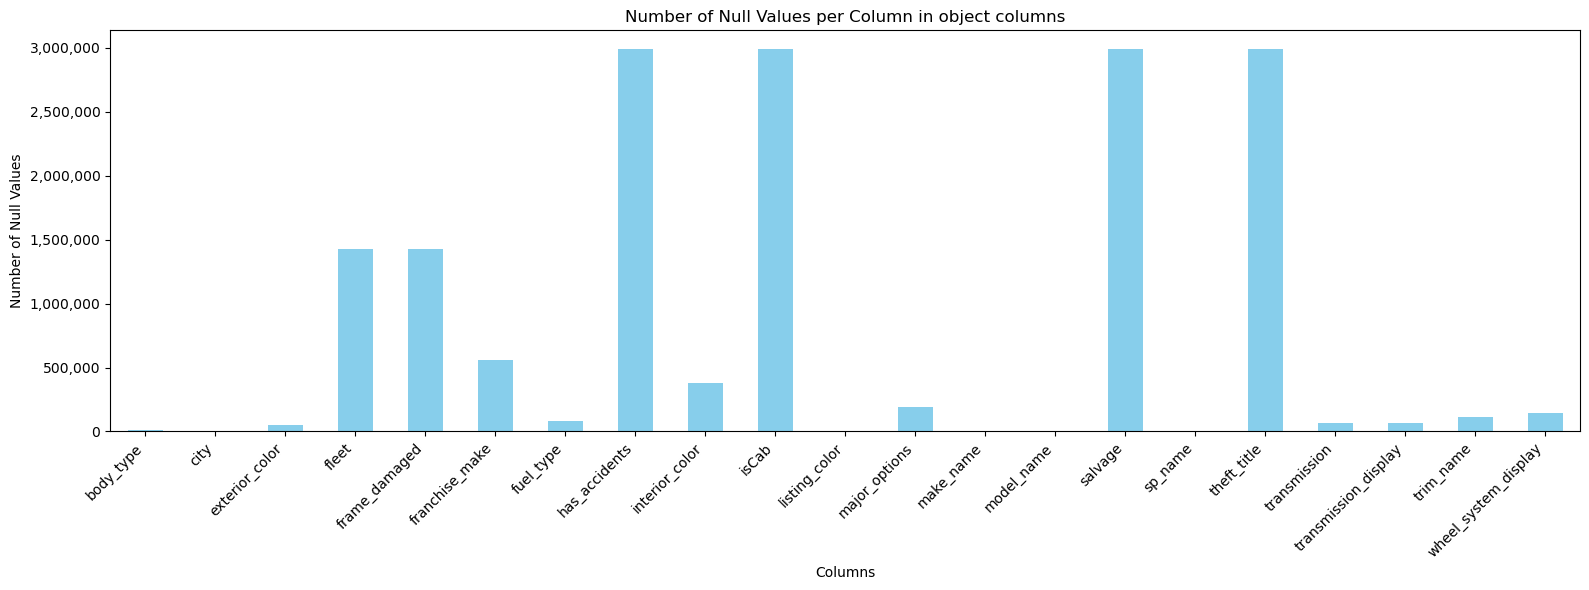

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
null_counts.plot.bar(color='skyblue')
plt.title('Number of Null Values per Column in object columns')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

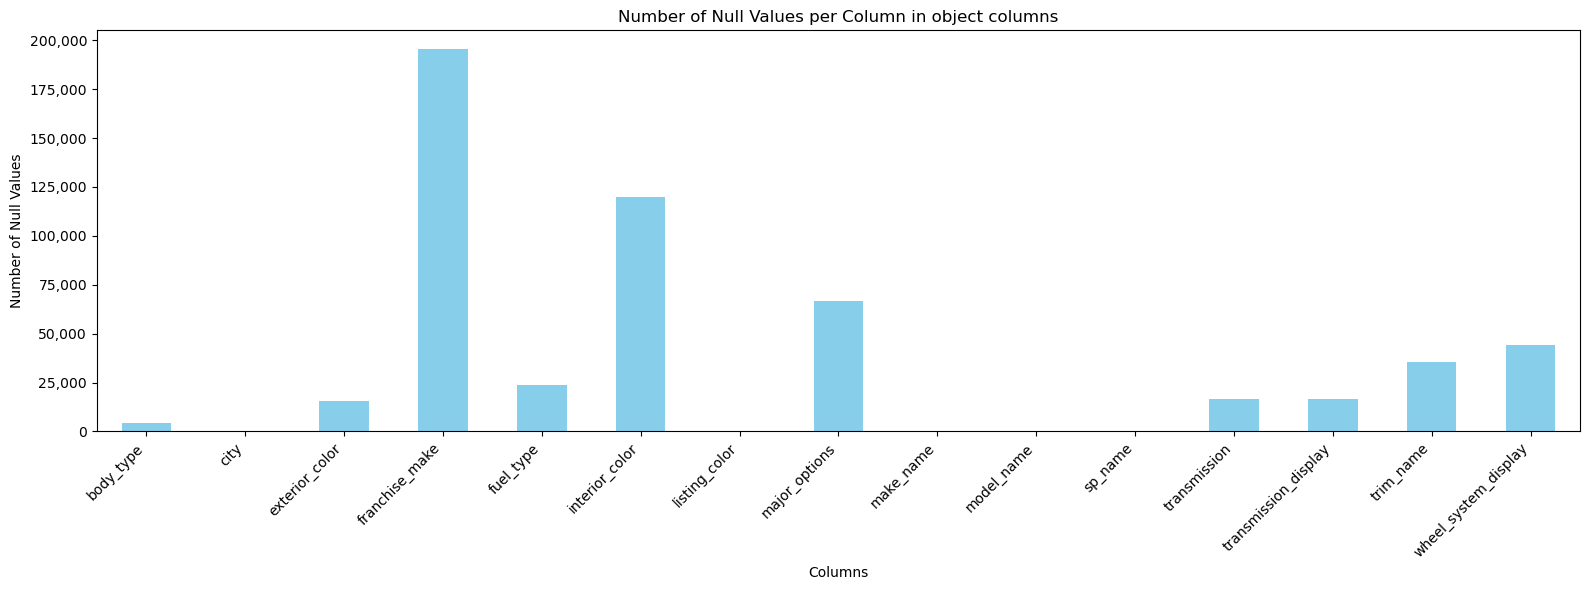

In [97]:
# Tämä kuva kun osa sarakkeiden tyypeistä oli muutettu/ poistettu, sis vaan 1 milj riviä, ei koko aineisto
# Vain vertauksen vuoksi tuohon edelliseen
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
null_counts.plot.bar(color='skyblue')
plt.title('Number of Null Values per Column in object columns')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

In [98]:
columns_to_check = ['front_legroom', 'fuel_tank_volume', 'height', 'maximum_seating', 
                    'power_hp', 'power_rpm', 'torque_rpm', 'wheelbase', 'width', 'back_legroom']

for col in columns_to_check:
    count = (dataframe[col] == '--').sum()
    print(f"Column '{col}' has {count} rows with '--'")
    

Column 'front_legroom' has 0 rows with '--'
Column 'fuel_tank_volume' has 0 rows with '--'
Column 'height' has 0 rows with '--'
Column 'maximum_seating' has 0 rows with '--'
Column 'power_hp' has 0 rows with '--'
Column 'power_rpm' has 0 rows with '--'
Column 'torque_rpm' has 0 rows with '--'
Column 'wheelbase' has 0 rows with '--'
Column 'width' has 0 rows with '--'
Column 'back_legroom' has 0 rows with '--'


In [99]:
a =('''
Muutettu objekteista numeeriseksi dataa. Joitakin booliksi meneviä jäänyt objektiksi NaN arvojen takia. Dropattu turhia sarakkeita.
Työstetty date column -> muutama uusi. Jotkut objektit vaativat työstöä encodingina varten. 
''')
print(a)


Muutettu objekteista numeeriseksi dataa. Joitakin booliksi meneviä jäänyt objektiksi NaN arvojen takia. Dropattu turhia sarakkeita.
Työstetty date column -> muutama uusi. Jotkut objektit vaativat työstöä encodingina varten. 



In [102]:
sara = ('''
Jouduin rullaamaan koodin nrows=1000000 rivillä kun ei oikein mennyt läpi koko datalla, eli voi alusta tuon poistaa ken kykenee datan ajaa koko datalla :D
Siistitty koodia ehkä selkeämpiin kokonaisuuksiin (mitä tehty missäkin vaiheessa), pudotettu sarakkeita ja muokattu tyyppejä, Valtteri oli kyllä jo hyvin alustanutkin tyyppimuunnoksia
One-hot-encoodaus varmaan tuonne missä muitakin sarakkeiden tyyppimuunnoksia.. voi olla kyllä muuallakin jos katsoo parhaaksi
''')
print(sara)


Jouduin rullaamaan koodin nrows=1000000 rivillä kun ei oikein mennyt läpi koko datalla, eli voi alusta tuon poistaa ken kykenee datan ajaa koko datalla :D
Siistitty koodia ehkä selkeämpiin kokonaisuuksiin (mitä tehty missäkin vaiheessa), pudotettu sarakkeita ja muokattu tyyppejä, Valtteri oli kyllä jo hyvin alustanutkin tyyppimuunnoksia
One-hot-encoodaus varmaan tuonne missä muitakin sarakkeiden tyyppimuunnoksia.. voi olla kyllä muuallakin jos katsoo parhaaksi

